# Models

Training and testing models: PSSM, HMM and ensemble of both

In [1]:
# Dependencies
import modules.pssm as pssm
import modules.hmm as hmm
from modules.ensemble import majority_voting
import modules.conf_mat as cmat
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Set matplotlib inline
%matplotlib inline

In [2]:
# Constants
SEQ_FASTA_PATH = 'data/domain.fasta'  # Input sequence (domain)
BLAST_FASTA_PATH = 'data/blast.fasta'  # Get sequence similarity search result
MSA_FASTA_PATH = 'data/msa.edited.fasta'  # Multiple sequence alignment (.fasta)
HUMAN_CSV_PATH = 'data/human.csv'  # Human proteome .csv dataset
HUMAN_FASTA_PATH = 'data/human.fasta'  # Human proteome .fasta dataset
FAMILIES_CSV_PATH = 'data/families.csv'  # Families .csv dataset
# Hidden Markov Model paths
HMMER_MODEL_PATH = 'models/model.hmm'  # Hidden Markov Model path
# PSSM paths
PSSM_MODEL_PATH = 'models/model.pssm'  # PSSM model path
# RESULTS
PSSM_RESULTS_PATH = 'data/results/pssm.tsv'  # PSSM model results
HMMER_RESULTS_PATH = 'data/results/hmmer.tsv'  # HMMER model results
JACK_RESULTS_PATH = 'data/results/jackhmmer.tsv'  # JACKHMMER model results
ENSEMBLE_RESULTS_PATH = 'data/results/ensemble.tsv'  # Ensemble model result

In [3]:
# Load protein families dataset
human_proteome = pd.read_csv(HUMAN_CSV_PATH, sep='\t')
human_proteome.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
0,Q9Y263,PLAP_HUMAN,Phospholipase A-2-activating protein (PLA2P) (...,795,WD repeat PLAP family,cell [GO:0005623]; cell junction [GO:0030054];...,2K89;2K8A;2K8B;2K8C;3EBB;,PF09070;PF08324;PF00400;,9606.ENSP00000380460;,1.10.150.410;1.25.10.10;2.130.10.10;,False
1,Q96RE7,NACC1_HUMAN,Nucleus accumbens-associated protein 1 (NAC-1)...,527,NaN,cell junction [GO:0030054]; cytoplasm [GO:0005...,3GA1;4U2N;,PF10523;PF00651;,9606.ENSP00000292431;,NaN,False
2,O43312,MTSS1_HUMAN,Protein MTSS 1 (Metastasis suppressor YGL-1) (...,755,MTSS family,actin cytoskeleton [GO:0015629]; cytoplasm [GO...,2D1K;,PF08397;PF02205;,9606.ENSP00000322804;,1.20.1270.60;,False
3,Q9NP80,PLPL8_HUMAN,Calcium-independent phospholipase A2-gamma (EC...,782,NaN,endoplasmic reticulum membrane [GO:0005789]; G...,NaN,PF01734;,9606.ENSP00000410804;,NaN,False
4,Q15319,PO4F3_HUMAN,"POU domain, class 4, transcription factor 3 (B...",338,"POU transcription factor family, Class-4 subfa...",cytoplasm [GO:0005737]; nuclear chromatin [GO:...,NaN,PF00046;PF00157;,9606.ENSP00000230732;,1.10.260.40;,False


In [66]:
# # Define function for turning matching ranges into positive positions
# def matches_to_pos(matches):
#     return set(pos for dom in matches.split(',') for pos in list(range(*[int(x) for x in dom.split('..')])))
# 
# # Load families positions dataset
# families_positions = pd.read_csv('data/families_positions.tsv', sep='\t')
# families_positions.columns = ['entry_ac', 'source_db', 'protein_name', 'tax_id',
#                               'tax_name', 'len', 'pfam_id', 'matches']
# # Take a subset of the original columns
# families_positions = families_positions[['entry_ac', 'matches']]
# # Merge human proteome with domain positions

TypeError: 'Series' object cannot be interpreted as an integer

In [4]:
# Define set of truly positive protein accessions
positive = set(human_proteome[human_proteome['PF00397']]['entry_ac'])
negative = set(human_proteome['entry_ac']) - positive

print('There are {:d} positive and {:d} negative proteins in human proteome'.format(
    len(positive), len(negative)
))

There are 38 positive and 20329 negative proteins in human proteome


## PSSM model

In [5]:
# Execute PSSM
try:
    # Fit the model
    pssm.fit(blast_path=BLAST_FASTA_PATH, msa_path=MSA_FASTA_PATH, model_path=PSSM_MODEL_PATH)
    # Evaluate the model
    pssm_out = pssm.test(model_path=PSSM_MODEL_PATH, test_path=HUMAN_FASTA_PATH,
                         num_iterations=4, e_value=1e-3)
    pssm_out = pssm.parse(pssm_out)
    
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [6]:
# Check pssm result
pssm_out.head()

,entry_ac,seq_start,seq_end,e_value
0,Q8N3X1,598,629,3.67e-10
1,Q8N3X1,220,248,3.73e-04
2,Q13526,7,39,1.18e-06
3,Q9BYW2,2391,2421,2.29e-05
4,O15428,7,39,2.33e-05


In [7]:
# Define set of positive protein accessions
pssm_positive = set(pssm_out['entry_ac'])
pssm_negative = set(human_proteome['entry_ac']) - pssm_positive

print('There are {:d} positive  and {:d} negative proteins matched by PSSM'.format(
    len(pssm_positive), len(pssm_negative)
))

There are 46 positive  and 20322 negative proteins matched by PSSM


In [8]:
# Define dataset of predicted positive rows
pssm_results = human_proteome[human_proteome.entry_ac.isin(pssm_positive)]
# Save results to disk
pssm_results.to_csv(PSSM_RESULTS_PATH, sep='\t', index=False)
# Show some lines
pssm_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True


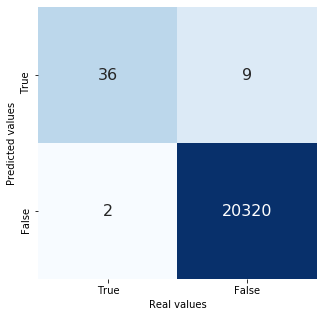

In [9]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=pssm_positive, 
              negative=negative, pred_negative=pssm_negative,
              ax=ax)
_ = plt.show()

## HMMER model

In [10]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Fit the HMM model
    hmm.fit(msa_path=MSA_FASTA_PATH, model_path=HMMER_MODEL_PATH)
    
    # Evaluate the model
    hmmer_out = hmm.test(test_path=HUMAN_FASTA_PATH, model_path=HMMER_MODEL_PATH, algorithm=hmm.HMMSEARCH)
    hmmer_out = hmm.parse(hmmer_out)
    
    # Make a threshold on e-value
    e_value = hmmer_out['e_value'].astype(float)
    hmmer_out = hmmer_out[e_value < e_value_threshold]
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [11]:
# Define set of positive protein accessions
hmmer_positive = set(hmmer_out['entry_ac'])
hmmer_negative = set(human_proteome['entry_ac']) - hmmer_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(hmmer_positive), len(hmmer_negative)
))

There are 28 positive  and 20339 negative proteins matched by HMM


In [12]:
# Define dataset of predicted positive rows
hmmer_results = human_proteome[human_proteome.entry_ac.isin(hmmer_positive)]
# Save results to disk
hmmer_results.to_csv(HMMER_RESULTS_PATH, sep='\t', index=False)
# Show some lines
hmmer_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True
3679,Q6AWC2,WWC2_HUMAN,Protein WWC2 (BH-3-only member B) (WW domain-c...,1192,WWC family,cytosol [GO:0005829]; kinase binding [GO:00199...,NaN,PF00397;,9606.ENSP00000384222;,2.60.40.150;,True
4895,Q9BYW2,SETD2_HUMAN,Histone-lysine N-methyltransferase SETD2 (EC 2...,2564,Class V-like SAM-binding methyltransferase sup...,chromosome [GO:0005694]; nucleoplasm [GO:00056...,2A7O;2MDC;2MDI;2MDJ;4FMU;4H12;5JJY;5JLB;5JLE;5...,PF17907;PF00856;PF08236;PF00397;,9606.ENSP00000386759;,1.10.1740.100;1.20.930.10;,True


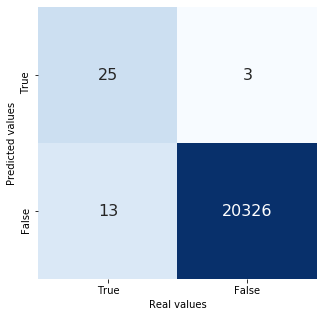

In [13]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=hmmer_positive, 
              negative=negative, pred_negative=hmmer_negative,
              ax=ax)
_ = plt.show()

## JACKHMMER

In [15]:
# Execute HMM

# Define e-value threshold
e_value_threshold = 0.7

# Run hmm
try:
    
    # Evaluate the model
    jack_out = hmm.test(test_path=HUMAN_FASTA_PATH, seq_path=SEQ_FASTA_PATH, algorithm=hmm.JACKHMMER)
    jack_out = hmm.parse(jack_out)
    
    # Make a threshold on e-value
    e_value = jack_out['e_value'].astype(float)
    jack_out = jack_out[e_value < e_value_threshold]
        
# Catch error
except subprocess.CalledProcessError as e:
    print(e)

In [17]:
# Define set of positive protein accessions
jack_positive = set(jack_out['entry_ac'])
jack_negative = set(human_proteome['entry_ac']) - jack_positive

print('There are {:d} positive  and {:d} negative proteins matched by HMM'.format(
    len(jack_positive), len(jack_negative)
))

There are 49 positive  and 20318 negative proteins matched by HMM


In [18]:
# Define dataset of predicted positive rows
jack_results = human_proteome[human_proteome.entry_ac.isin(jack_positive)]
# Save results to disk
jack_results.to_csv(JACK_RESULTS_PATH, sep='\t', index=False)
# Show some lines
jack_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2520,Q5VWI1,TCRGL_HUMAN,Transcription elongation regulator 1-like protein,586,NaN,nucleus [GO:0005634],NaN,PF01846;,9606.ENSP00000357631;,1.10.10.440;,False


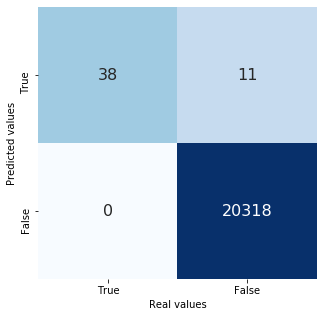

In [19]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=jack_positive, 
              negative=negative, pred_negative=jack_negative,
              ax=ax)
_ = plt.show()

## Ensemble model

Here the ensemble of PSSM and HMM prediction are kept as ensemble model prediction. Then, ensemble model prediction output is evaluated.

In [20]:
# Define ensemble predictions as union of PSSM and HMM results
ensemble_positive, ensemble_negative = majority_voting(threshold=2, models_out=[
    (pssm_positive, pssm_negative),  # PSSM
    (hmmer_positive, hmmer_negative),  # HMMER
    (jack_positive, jack_negative)  # JACKHMMER
])

print('There are {:d} positive and {:d} negative proteins matched by HMM'.format(
    len(ensemble_positive), len(ensemble_negative)
))

There are 47 positive and 20344 negative proteins matched by HMM


In [21]:
# Define dataset of predicted positive rows
ensemble_results = human_proteome[human_proteome.entry_ac.isin(ensemble_positive)]
# Save results to disk
ensemble_results.to_csv(ENSEMBLE_RESULTS_PATH, sep='\t', index=False)
# Show some lines
ensemble_results.head()

,entry_ac,entry_name,protein_name,len,domains,go,pdb_ids,pfam_ids,string_id,cath_ids,PF00397
428,Q9BTA9,WAC_HUMAN,WW domain-containing adapter protein with coil...,647,NaN,nuclear speck [GO:0016607]; nucleoplasm [GO:00...,NaN,PF00397;,9606.ENSP00000346986;,NaN,True
871,Q9NZC7,WWOX_HUMAN,WW domain-containing oxidoreductase (EC 1.1.1....,414,Short-chain dehydrogenases/reductases (SDR) fa...,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,1WMV;,PF00106;PF00397;,9606.ENSP00000457230;,NaN,True
966,Q9GZV5,WWTR1_HUMAN,WW domain-containing transcription regulator p...,400,NaN,cytoplasm [GO:0005737]; cytosol [GO:0005829]; ...,5N5R;5N5T;5N5W;5N75;,PF00397;,9606.ENSP00000419465;,NaN,True
2246,Q8N3X1,FNBP4_HUMAN,Formin-binding protein 4 (Formin-binding prote...,1017,NaN,nuclear speck [GO:0016607],NaN,PF00397;,9606.ENSP00000263773;,NaN,True
2780,O15428,PINL_HUMAN,Putative PIN1-like protein (Peptidylprolyl cis...,100,NaN,cytosol [GO:0005829]; nucleus [GO:0005634]; pe...,NaN,PF00397;,NaN,NaN,True


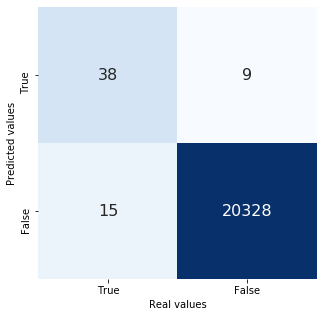

In [22]:
# Show confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
_ = cmat.plot(positive=positive, pred_positive=ensemble_positive, 
              negative=negative, pred_negative=ensemble_negative,
              ax=ax)
_ = plt.show()

## Model comparison

Here various metrics are compared for all the different models.

In [23]:
# Define a dictionary model -> predicted positive set
models = {
    'pssm': {
        'positive': pssm_positive, 
        'negative': pssm_negative
    },
    'hmmer': {
        'positive': hmmer_positive,
        'negative': hmmer_negative
    },
    'jackhmmer': {
        'positive': jack_positive,
        'negative': jack_negative
    },
    'ensemble': {
        'positive': ensemble_positive, 
        'negative': ensemble_negative
    }
}

In [24]:
# Compute statistics for each model
for model, attr in models.items():
    # Compute scores for current model (precision, recall, accuracy, weighted accuracy)
    _ , prc, rec, acc, w_acc = cmat.compute(positive=positive, pred_positive=attr['positive'],
                                            negative=negative, pred_negative=attr['negative'])
    # Add scores to each model
    models[model]['prc'] = prc
    models[model]['rec'] = rec
    models[model]['acc'] = acc
    models[model]['w_acc'] = w_acc

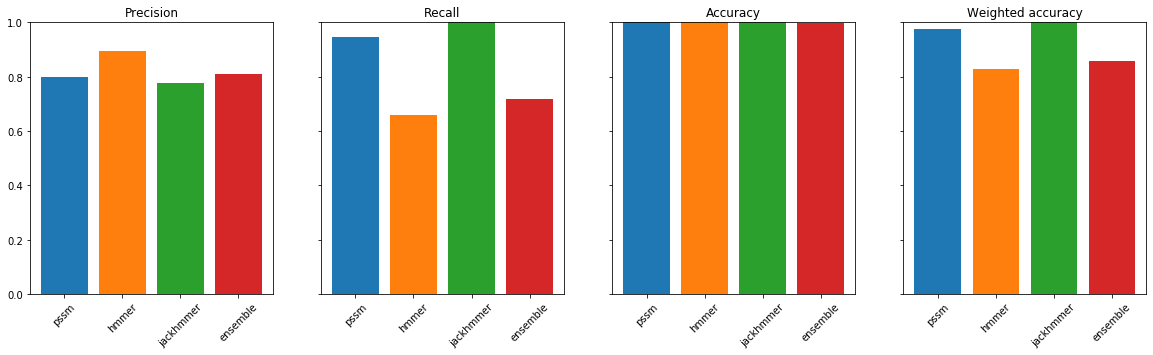

In [25]:
# Show statistics comparison

# Initialize plot: one for each statistic
fig, axs = plt.subplots(1, 4, figsize=(20, 5), sharey=True)
# Define titles for each statistic
_ = axs[0].set_title('Precision')
_ = axs[1].set_title('Recall')
_ = axs[2].set_title('Accuracy')
_ = axs[3].set_title('Weighted accuracy')

# Create a barplot for each statistic
# Fill values for each model
for i, model in enumerate(models.keys()):
    _ = axs[0].bar(i, models[model]['prc'])  # Precision
    _ = axs[1].bar(i, models[model]['rec'])  # Recall
    _ = axs[2].bar(i, models[model]['acc'])  # Accuracy
    _ = axs[3].bar(i, models[model]['w_acc'])  # Weighted accuracy
    
# Set properties for each plot
for i in range(4):
    # Set labels
    _ = axs[i].set_xticks(range(len(models.keys())))
    _ = axs[i].set_xticklabels(list(models.keys()), rotation=45)
    # Set limits
    _ = axs[i].set_ylim(0.0, 1.0)
    
# Show plot
plt.show()